A figure combining Figs 4 and S6, but this time only for "true duplicates" (simulated pairs for which the loss of a copy would still be deleterious at the end of the simulation) is constructed as Fig S15.

In [ ]:
from google.colab import files
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 600
import seaborn as sns
from matplotlib import cm
import scipy.stats as stats
from matplotlib.lines import Line2D
from matplotlib import ticker
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

In [ ]:
# Mounting my google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1) Preparing data for the heatmaps of mean KS statistics for the grid search of parameter values

The summary statistics (including the KS statistics which will be used) are first imnported, both for the N=10^6 and N=10^5 scenarios 

In [ ]:
dist_comps_1e6 = pd.read_csv('/content/drive/My Drive/Redaction_SA/Final_figures_v2/Summ_stats_dists/Dist_stats_all_Mut_SD_WGD.csv')
dist_comps_1e5 = pd.read_csv('/content/drive/My Drive/Redaction_SA/Final_figures_v2/Summ_stats_dists/Dist_stats_all_Mut_SD_WGD_1e5.csv')

In both cases, only the relevant values are kept:

In [ ]:
KS_comps_1e6 = dist_comps_1e6[(dist_comps_1e6['Comparison'] == 'WGD') & (dist_comps_1e6['Property'] != 'Divergence ratio') & (dist_comps_1e6['Type'] == 'True duplicates')].copy().reset_index(drop=True)
KS_comps_1e5 = dist_comps_1e5[(dist_comps_1e5['Comparison'] == 'WGD') & (dist_comps_1e5['Property'] != 'Divergence ratio') & (dist_comps_1e5['Type'] == 'True duplicates')].copy().reset_index(drop=True)

Matrices are prepared for the mixed (economy-precision) and minimal models

In [ ]:
# Dictionary of mutational target size ratios
run_ratio = {'0.5': '1/2', '1.0': '1', '2.0': '2', '3.0': '3', '4.0': '4', 
             '5.0': '5', '6.0': '6', '7.0': '7', '8.0': '8', '9.0': '9', 
             '10.0': '10'}

In [ ]:
KS_comps_1e6 = KS_comps_1e6.astype({'Mut_ratio': 'string'})
KS_comps_1e5 = KS_comps_1e5.astype({'Mut_ratio': 'string'})

for row in range(KS_comps_1e6.shape[0]):
  KS_comps_1e6.at[row, 'Mut_ratio'] = run_ratio[KS_comps_1e6.at[row, 'Mut_ratio']]

for row in range(KS_comps_1e5.shape[0]):
  KS_comps_1e5.at[row, 'Mut_ratio'] = run_ratio[KS_comps_1e5.at[row, 'Mut_ratio']]

# Dropping all unused columns
KS_comps_1e6 = KS_comps_1e6[['Model', 'Mut_sigma', 'Mut_ratio', 'KS_stat']]
KS_comps_1e5 = KS_comps_1e5[['Model', 'Mut_sigma', 'Mut_ratio', 'KS_stat']]

# Computing the means and making distinct dataframes for the two models
means_1e6 = KS_comps_1e6.groupby(by=['Model', 'Mut_sigma', 'Mut_ratio'], as_index=False).mean()
means_1e5 = KS_comps_1e5.groupby(by=['Model', 'Mut_sigma', 'Mut_ratio'], as_index=False).mean()

mixed_1e6 = means_1e6[means_1e6['Model'] == 'Mixed'].copy().reset_index(drop=True)
min_1e6 = means_1e6[means_1e6['Model'] == 'Minimal'].copy().reset_index(drop=True)

mixed_1e5 = means_1e5[means_1e5['Model'] == 'Mixed'].copy().reset_index(drop=True)
min_1e5 = means_1e5[means_1e5['Model'] == 'Minimal'].copy().reset_index(drop=True)

In [ ]:
# Making the four matrices
KS_min_1e6 = min_1e6.pivot(index='Mut_sigma', columns='Mut_ratio',
                           values='KS_stat')
KS_mixed_1e6 = mixed_1e6.pivot(index='Mut_sigma', columns='Mut_ratio',
                               values='KS_stat')

KS_min_1e5 = min_1e5.pivot(index='Mut_sigma', columns='Mut_ratio',
                           values='KS_stat')
KS_mixed_1e5 = mixed_1e5.pivot(index='Mut_sigma', columns='Mut_ratio',
                               values='KS_stat')

In [ ]:
# For reordering the matrices
columns = ['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

# Reordering each matrix
KS_min_1e6 = KS_min_1e6.reindex(labels=columns, axis='columns')
KS_mixed_1e6 = KS_mixed_1e6.reindex(labels=columns, axis='columns')
KS_min_1e5 = KS_min_1e5.reindex(labels=columns, axis='columns')
KS_mixed_1e5 = KS_mixed_1e5.reindex(labels=columns, axis='columns')

In [ ]:
# Mins and max for the color scales
min_KS = np.min((min_1e6['KS_stat'].min(), min_1e5['KS_stat'].min(),
                 mixed_1e6['KS_stat'].min(), mixed_1e5['KS_stat'].min()))
max_KS = np.max((min_1e6['KS_stat'].max(), min_1e5['KS_stat'].max(),
                 mixed_1e6['KS_stat'].max(), mixed_1e5['KS_stat'].max()))

## 2) Empirical divergence correlations and their 95% confidence intervals (for the part where Fig4 is reproduced)

In [ ]:
# Function to compute the confidence interval on spearman rho
def spearman_ci(x, y, ci=95, n_boots=10000, seed=22):
  x = np.asarray(x)
  y = np.asarray(y)

  # (n_boots, n_observations) paired arrays
  rng = np.random.default_rng(seed) # For reproducible bootstrapping
  rand_ixs = rng.integers(0, x.shape[0], size=(n_boots, x.shape[0]))
  x_boots = x[rand_ixs]
  y_boots = y[rand_ixs]

  # Spearman correlations
  corrs = []

  for row in range(x_boots.shape[0]):
    rho = stats.spearmanr(x_boots[row, :], y_boots[row, :])
    corrs.append(rho[0])

  # Quantiles of correlations coefficients and confidence interval
  corrs = np.asarray(corrs)

  ci_low = np.percentile(corrs, (100 - ci) / 2)
  ci_high = np.percentile(corrs, (ci + 100) / 2)

  return ci_low, ci_high, corrs

In [ ]:
# Empirical divergence data is imported
couples_divergence = pd.read_csv('/content/drive/My Drive/Redaction_SA/'
                                 'Final_figures/Data_sim_ready/'
                                 'couples_divergence.csv')

# Only WGD-derived pairs are kept
couples_divergence = couples_divergence[couples_divergence['Duplication'] == 'WGD'].reset_index(drop=True)

In [ ]:
# Confidence interval on the empirical correlation of divergence
rho_emp = spearman_ci(couples_divergence['bm_fold_original'],
                      couples_divergence['bp_fold_original'])
spearman_ci_div = (rho_emp[0], rho_emp[1])
dist_boot_div = rho_emp[2]

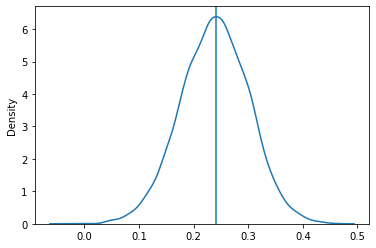

In [ ]:
# Quick validation that bootstrapping is valid:
center_div = stats.spearmanr(couples_divergence['bm_fold_original'],
                         couples_divergence['bp_fold_original'])[0]

sns.kdeplot(dist_boot_div)
plt.axvline(x=center_div)

The 95% confidence interval is also computed for the signed divergence correlation:

In this case, a duplicated dataset is used, so that logfold changes are computed in the two possible orientations for each paralog pair

In [ ]:
couples_divergence['bm_fold_signed_1'] = np.log2((10**couples_divergence['bm_P1']) / (10**couples_divergence['bm_P2']))
couples_divergence['bp_fold_signed_1'] = np.log2((10**couples_divergence['bp_P1']) / (10**couples_divergence['bp_P2']))
couples_divergence['bm_fold_signed_2'] = np.log2((10**couples_divergence['bm_P2']) / (10**couples_divergence['bm_P1']))
couples_divergence['bp_fold_signed_2'] = np.log2((10**couples_divergence['bp_P2']) / (10**couples_divergence['bp_P1']))

In [ ]:
logfold_dupli_1 = couples_divergence[['Duplication', 'ORF_P1', 'ORF_P2',
                                    'bm_fold_signed_1', 'bp_fold_signed_1']].copy()

logfold_dupli_1.columns = ['Duplication', 'ORF_P1', 'ORF_P2',
                          'bm_fold_signed', 'bp_fold_signed']


logfold_dupli_2 = couples_divergence[['Duplication', 'ORF_P1', 'ORF_P2',
                                    'bm_fold_signed_2', 'bp_fold_signed_2']].copy()

logfold_dupli_2.columns = ['Duplication', 'ORF_P1', 'ORF_P2',
                          'bm_fold_signed', 'bp_fold_signed']

logfold_dupli = pd.concat([logfold_dupli_1, logfold_dupli_2])

In [ ]:
# Confidence interval on the empirical correlation of divergence
rho_emp = spearman_ci(logfold_dupli['bm_fold_signed'],
                      logfold_dupli['bp_fold_signed'])
spearman_ci_sign = (rho_emp[0], rho_emp[1])
dist_boot_sign = rho_emp[2]

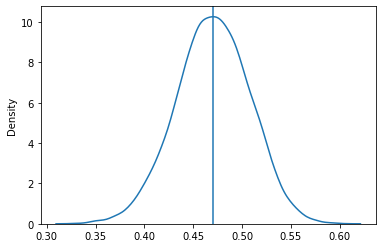

In [ ]:
# Quick validation that bootstrapping is valid:
center_sign = stats.spearmanr(logfold_dupli['bm_fold_signed'],
                              logfold_dupli['bp_fold_signed'])[0]

sns.kdeplot(dist_boot_sign)
plt.axvline(x=center_sign)

## 3) Preparation of summary statistics (KS stats and correlation coefficients) for the swarmplots as in Fig 4

Importing the KS stats

In [ ]:
dist_comps_1e6 = pd.read_csv('/content/drive/My Drive/Redaction_SA/Final_figures_v2/Summ_stats_dists/Dist_stats_all_Mut_SD_WGD.csv')
dist_comps_1e5 = pd.read_csv('/content/drive/My Drive/Redaction_SA/Final_figures_v2/Summ_stats_dists/Dist_stats_all_Mut_SD_WGD_1e5.csv')

Importing the correlations

In [ ]:
corrs_1e6 = pd.read_csv('/content/drive/My Drive/Redaction_SA/Final_figures_v2/Summ_stats_dists/Correlations_all_Mut_SD_WGD.csv')
corrs_1e5 = pd.read_csv('/content/drive/My Drive/Redaction_SA/Final_figures_v2/Summ_stats_dists/Correlations_all_Mut_SD_WGD_1e5.csv')

Reformatting the 'Mut_ratio' column 

In [ ]:
# Dictionary of mutational target size ratios
run_ratio = {'0.5': '1/2', '1.0': '1', '2.0': '2', '3.0': '3', '4.0': '4', 
             '5.0': '5', '6.0': '6', '7.0': '7', '8.0': '8', '9.0': '9', 
             '10.0': '10'}
model_convert = {'Mixed': 'Precision-economy', 'No Cost': 'No Cost',
                 'ADS': 'ADS', 'Minimal': 'Minimal'}

In [ ]:
dist_comps_1e6 = dist_comps_1e6.astype({'Mut_ratio': 'string'})
dist_comps_1e5 = dist_comps_1e5.astype({'Mut_ratio': 'string'})
corrs_1e6 = corrs_1e6.astype({'Mut_ratio': 'string'})
corrs_1e5 = corrs_1e5.astype({'Mut_ratio': 'string'})

for row in range(dist_comps_1e6.shape[0]):
  dist_comps_1e6.at[row, 'Mut_ratio'] = run_ratio[dist_comps_1e6.at[row, 'Mut_ratio']]
  dist_comps_1e6.at[row, 'Model'] = model_convert[dist_comps_1e6.at[row, 'Model']]

for row in range(dist_comps_1e5.shape[0]):
  dist_comps_1e5.at[row, 'Mut_ratio'] = run_ratio[dist_comps_1e5.at[row, 'Mut_ratio']]
  dist_comps_1e5.at[row, 'Model'] = model_convert[dist_comps_1e5.at[row, 'Model']]

for row in range(corrs_1e6.shape[0]):
  corrs_1e6.at[row, 'Mut_ratio'] = run_ratio[corrs_1e6.at[row, 'Mut_ratio']]
  corrs_1e6.at[row, 'Model'] = model_convert[corrs_1e6.at[row, 'Model']]


for row in range(corrs_1e5.shape[0]):
  corrs_1e5.at[row, 'Mut_ratio'] = run_ratio[corrs_1e5.at[row, 'Mut_ratio']]
  corrs_1e5.at[row, 'Model'] = model_convert[corrs_1e5.at[row, 'Model']]

Computing the mean KS statistics

In [ ]:
# Values concerning the distribution of divergence ratios are first dropped
dist_comps_1e6 = dist_comps_1e6[dist_comps_1e6['Property'] != 'Divergence ratio'].reset_index(drop=True)
dist_comps_1e5 = dist_comps_1e5[dist_comps_1e5['Property'] != 'Divergence ratio'].reset_index(drop=True)

In [ ]:
KS_means_1e6 = dist_comps_1e6.groupby(by=['Model', 'Mut_sigma', 'Mut_ratio', 'Iter', 'Comparison', 'Type'], as_index=False).mean().copy().reset_index(drop=True)
KS_means_1e6 = KS_means_1e6[['Model', 'Mut_sigma', 'Mut_ratio', 'Comparison', 'Type', 'Moods_stat', 'Moods_p-val', 'KS_stat', 'KS_p-val']]
KS_means_1e5 = dist_comps_1e5.groupby(by=['Model', 'Mut_sigma', 'Mut_ratio', 'Iter', 'Comparison', 'Type'], as_index=False).mean().copy().reset_index(drop=True)
KS_means_1e5 = KS_means_1e5[['Model', 'Mut_sigma', 'Mut_ratio', 'Comparison', 'Type', 'Moods_stat', 'Moods_p-val', 'KS_stat', 'KS_p-val']]

Keeping only the data which is relevant for the figure

In [ ]:
KS_1e6_ready = KS_means_1e6[(KS_means_1e6['Model'] != 'ADS') & (KS_means_1e6['Model'] != 'No Cost') & (KS_means_1e6['Comparison'] == 'WGD') & (KS_means_1e6['Type'] == 'True duplicates') & (KS_means_1e6['Mut_sigma'] == 0.01)].reset_index(drop=True)
KS_1e5_ready = KS_means_1e5[(KS_means_1e5['Model'] != 'ADS') & (KS_means_1e5['Model'] != 'No Cost') & (KS_means_1e5['Comparison'] == 'WGD') & (KS_means_1e5['Type'] == 'True duplicates') & (KS_means_1e5['Mut_sigma'] == 0.05)].reset_index(drop=True)

For the correlations, also keeping only the rows which are relevant for the construction of the figure

In [ ]:
corrs_1e6_ready = corrs_1e6[(corrs_1e6['Model'] != 'ADS') & (corrs_1e6['Model'] != 'No Cost') & (corrs_1e6['Type'] == 'True duplicates') & (corrs_1e6['Mut_sigma'] == 0.01)].reset_index(drop=True)
corrs_1e5_ready = corrs_1e5[(corrs_1e5['Model'] != 'ADS') & (corrs_1e5['Model'] != 'No Cost') & (corrs_1e5['Type'] == 'True duplicates') & (corrs_1e5['Mut_sigma'] == 0.05)].reset_index(drop=True)

## 4) Construction of the figure

Two figures are made, and then assembled in inkscape

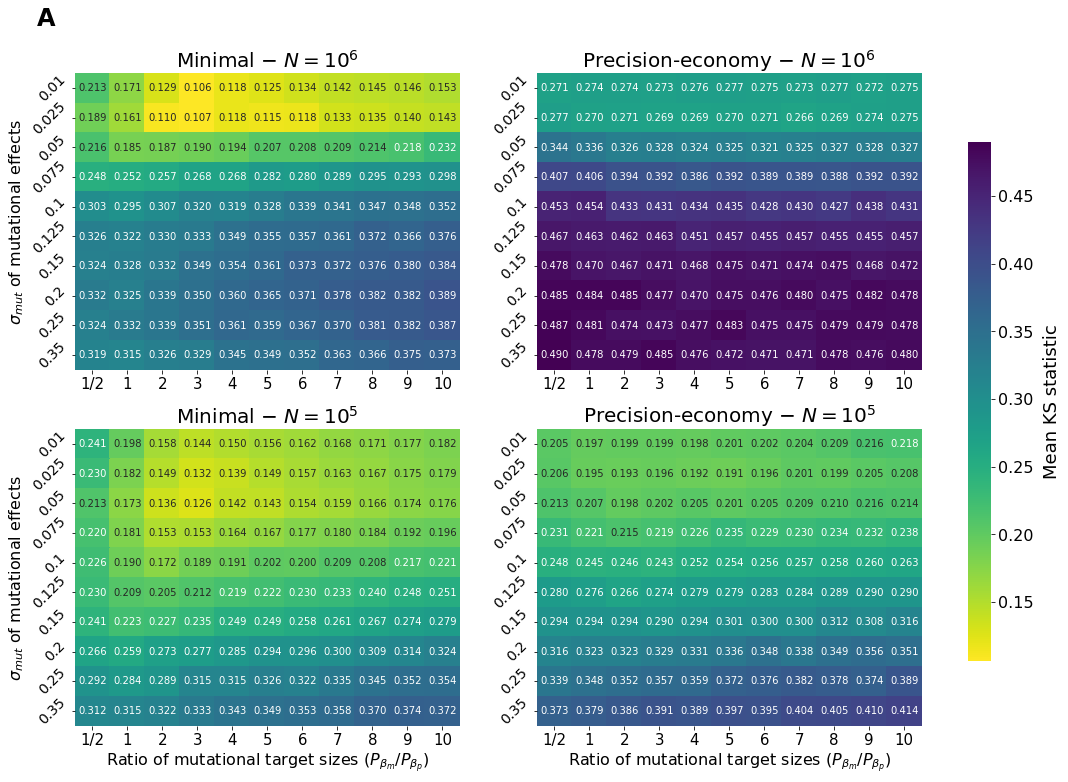

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

fig.subplots_adjust(right=0.86)
cbar_ax = fig.add_axes([0.9, 0.20, 0.02, 0.6])


# Minimal model
heat1 = sns.heatmap(KS_min_1e6, vmin=min_KS, vmax=max_KS, cmap='viridis_r', 
                    ax=axs[0,0], annot=True, fmt = '.3f', cbar_ax=cbar_ax)

heat2 = sns.heatmap(KS_min_1e5, vmin=min_KS, vmax=max_KS, cmap='viridis_r', 
                    ax=axs[1,0], annot=True, fmt = '.3f', cbar=False)

# Cost-precision model
heat3 = sns.heatmap(KS_mixed_1e6, vmin=min_KS, vmax=max_KS, cmap='viridis_r', 
                    ax=axs[0,1], annot=True, fmt = '.3f', cbar=False)

heat4 = sns.heatmap(KS_mixed_1e5, vmin=min_KS, vmax=max_KS, cmap='viridis_r', 
                    ax=axs[1,1], annot=True, fmt = '.3f', cbar=False)

# cbar labels
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size=16)
cbar_ax.set_ylabel('Mean KS statistic', size=18, labelpad=10)

# Heatmaps axes
for ax in [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]:
  ax.set_xticklabels(ax.get_xmajorticklabels(), size=15)
  
  ax.set_yticklabels(ax.get_ymajorticklabels(), size=14, rotation=45)

# Axes labels
axs[0,0].set_ylabel(r"$\sigma_{mut}$ of mutational effects", fontsize=16)
axs[1,0].set_ylabel(r"$\sigma_{mut}$ of mutational effects", fontsize=16)
axs[0,1].set_ylabel('')
axs[1,1].set_ylabel('')

axs[0,0].set_xlabel('')
axs[0,1].set_xlabel('')

axs[1,0].set_xlabel(r"Ratio of mutational target sizes ($P_{\beta_m}$/$P_{\beta_p}$)", 
                    fontsize=16)
axs[1,1].set_xlabel(r"Ratio of mutational target sizes ($P_{\beta_m}$/$P_{\beta_p}$)", 
                    fontsize=16)

# Titles
axs[0,0].set_title(r"Minimal $-$ $N = 10^6$", fontsize=20)
axs[0,1].set_title(r"Precision-economy $-$ $N = 10^6$", fontsize=20)
axs[1,0].set_title(r"Minimal $-$ $N = 10^5$", fontsize=20)
axs[1,1].set_title(r"Precision-economy $-$ $N = 10^5$", fontsize=20)

# Figure annotations
axs[0,0].annotate('A', (-0.1, 1.16), xycoords='axes fraction', 
                  fontsize=24, fontweight='bold')

FigS15_A = plt.gcf()
FigS15_A.savefig('/content/drive/My Drive/Redaction_SA/Final_figures_v2/FigS15_A.svg',
                 bbox_inches='tight')

Part B: Swarmplots as in Fig 4

Dodge and jitter are first added to each dataframe

In [ ]:
# Adding new coordinates with dodge and jitter
sym_to_num = {'1/2':1, '1':2, '2':3, '3':4, '4':5, '5':6, '6':7, '7':8,
              '8':9, '9':10, '10':11}

# Adding the 'num' column which will be used
KS_1e6_ready['num'] = np.NaN
KS_1e5_ready['num'] = np.NaN
corrs_1e6_ready['num'] = np.NaN
corrs_1e5_ready['num'] = np.NaN

for row in range(KS_1e6_ready.shape[0]):
  KS_1e6_ready.at[row, 'num'] = sym_to_num[KS_1e6_ready.at[row, 'Mut_ratio']]

for row in range(corrs_1e6_ready.shape[0]):
  corrs_1e6_ready.at[row, 'num'] = sym_to_num[corrs_1e6_ready.at[row, 'Mut_ratio']]

for row in range(KS_1e5_ready.shape[0]):
  KS_1e5_ready.at[row, 'num'] = sym_to_num[KS_1e5_ready.at[row, 'Mut_ratio']]

for row in range(corrs_1e5_ready.shape[0]):
  corrs_1e5_ready.at[row, 'num'] = sym_to_num[corrs_1e5_ready.at[row, 'Mut_ratio']]

# Add dodge
dodge_dict = {'Minimal':0.1875, 'Precision-economy':0.0625}

for row in range(KS_1e6_ready.shape[0]):
  KS_1e6_ready.at[row, 'num'] = KS_1e6_ready.at[row, 'num'] + dodge_dict[KS_1e6_ready.at[row, 'Model']]

for row in range(corrs_1e6_ready.shape[0]):
  corrs_1e6_ready.at[row, 'num'] = corrs_1e6_ready.at[row, 'num'] + dodge_dict[corrs_1e6_ready.at[row, 'Model']]

for row in range(KS_1e5_ready.shape[0]):
  KS_1e5_ready.at[row, 'num'] = KS_1e5_ready.at[row, 'num'] + dodge_dict[KS_1e5_ready.at[row, 'Model']]

for row in range(corrs_1e5_ready.shape[0]):
  corrs_1e5_ready.at[row, 'num'] = corrs_1e5_ready.at[row, 'num'] + dodge_dict[corrs_1e5_ready.at[row, 'Model']]

# Add jitter
def jitter(x):
  return x + np.random.uniform(-0.1, 0.1)

KS_1e6_ready['num'] = KS_1e6_ready['num'].apply(lambda x: jitter(x))
corrs_1e6_ready['num'] = corrs_1e6_ready['num'].apply(lambda x: jitter(x))
KS_1e5_ready['num'] = KS_1e5_ready['num'].apply(lambda x: jitter(x))
corrs_1e5_ready['num'] = corrs_1e5_ready['num'].apply(lambda x: jitter(x))

In [ ]:
# A function is defined to plot data with markers and colors for hue-levels
# without using seaborn

def hue_scatter(x, y, data, hue, palette, hue_order, markers, ax, size=None, 
                facecolors=None, alpha=None, linewidths=None):
  # Loop through hue orders and plot the points
  for level in hue_order:
    subset = data[data[hue] == level].copy().reset_index(drop=True)

    if facecolors == 'none':
      ax.scatter(subset[x], subset[y], s=size,
                 marker=markers[level], alpha=alpha, linewidths=linewidths,
                 label=level, facecolors=facecolors, edgecolors=palette[level])
      
    else:
      ax.scatter(subset[x], subset[y], s=size, c=palette[level],
                 marker=markers[level], alpha=alpha, linewidths=linewidths,
                 label=level, facecolors=facecolors)

<ipython-input-29-e045658c70d7>:177: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  FigS15_B.savefig('/content/drive/My Drive/Redaction_SA/Final_figures_v2/'
/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


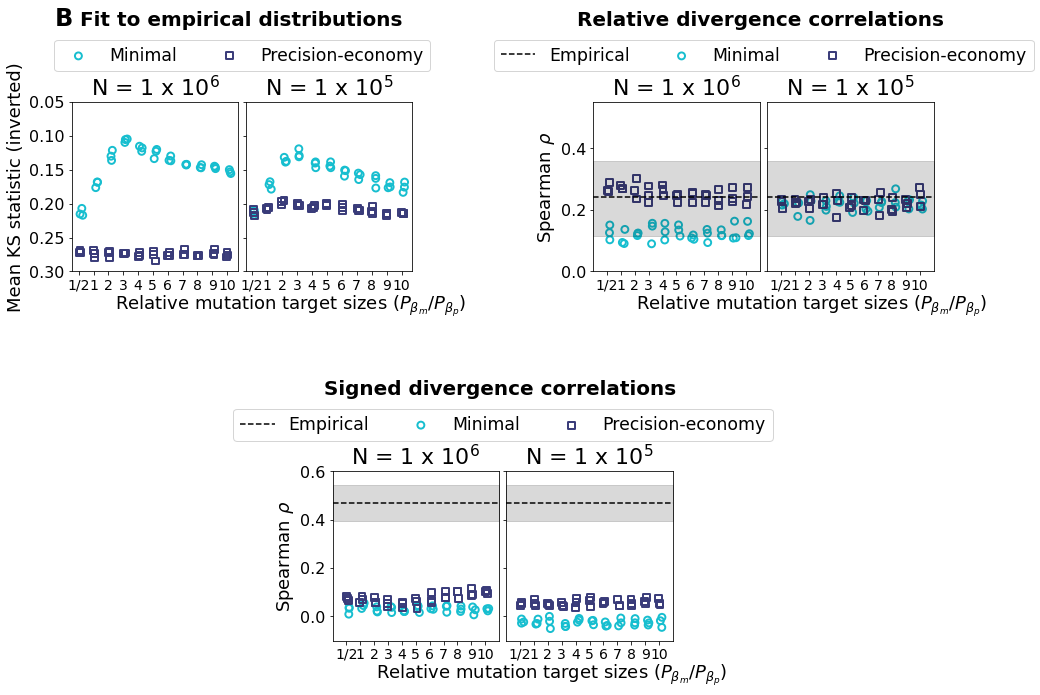

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(17, 15))

# Preparation of the grids and axes
gs0 = fig.add_gridspec(9, 11)

gs01 = gs0[3:5, :].subgridspec(1, 22)
gs02 = gs0[7:, :].subgridspec(1, 22)

ax1 = fig.add_subplot(gs01[:, 1:5])
ax2 = fig.add_subplot(gs01[:, 5:9])

ax3 = fig.add_subplot(gs01[:, 13:17])
ax4 = fig.add_subplot(gs01[:, 17:21])

ax5 = fig.add_subplot(gs02[:, 7:11])
ax6 = fig.add_subplot(gs02[:, 11:15])

# Adding panel A
#ax0.imshow(schema_4A)

# Parameters for the scatterplots
labels = ['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

size = 48

palette = {'Precision-economy': cm.tab20b.colors[0], 'Minimal': cm.tab10.colors[9]}
hue_order = ['Minimal', 'Precision-economy']
markers = {'Precision-economy': 's', 'Minimal':'o'}

facecolors = 'none'

linewidths = 1.95

# First two scatterplots: KS statistics
min_KS = 0.050
max_KS = 0.30

scatter1 = hue_scatter('num', 'KS_stat', KS_1e6_ready, 'Model', palette,
                       hue_order, markers, ax1, size=size,
                       facecolors=facecolors, linewidths=linewidths)

plt.sca(ax1) 
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax1.set_xticklabels(['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.ylim(bottom=min_KS, top=max_KS)
plt.tick_params(labelsize=16)

plt.gca().invert_yaxis() # Invert y-axis for KS stats

scatter2 = hue_scatter('num', 'KS_stat', KS_1e5_ready, 'Model', palette, 
                       hue_order, markers, ax2, size=size,
                       facecolors=facecolors, linewidths=linewidths)

plt.sca(ax2) 
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax2.set_xticklabels(['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.ylim(bottom=min_KS, top=max_KS)
plt.tick_params(labelsize=16)

plt.gca().invert_yaxis() # Invert y-axis for KS stats

# Next two scatterplots: Correlations between the log2-fold changes
min_div = 0
max_div = 0.55

scatter3 = hue_scatter('num', 'rho_fold', corrs_1e6_ready, 'Model', palette, 
                       hue_order, markers, ax3, size=size, 
                       facecolors=facecolors, linewidths=linewidths)
plt.sca(ax3) 
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax3.set_xticklabels(['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.ylim(bottom=min_div, top=max_div)
plt.tick_params(labelsize=16)

scatter4 = hue_scatter('num', 'rho_fold', corrs_1e5_ready, 'Model', palette, 
                       hue_order, markers, ax4, size=size,
                       facecolors=facecolors, linewidths=linewidths)
plt.sca(ax4) 
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax4.set_xticklabels(['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.ylim(bottom=min_div, top=max_div)
plt.tick_params(labelsize=16)

# Addition of the empirical correlation + 95% CI to scatters of correlation
for ax in [ax3, ax4]:
  ax.set_xlim(left=0, right=12)
  x_lims = ax.get_xlim()
  ax.axhline(y=center_div, c='k', linestyle='--', label='Empirical')
  ax.fill_between(x_lims, spearman_ci_div[0], spearman_ci_div[1], 
                  color='black', alpha=0.15)
  
# Last two scatterplots: Correlations between the signed relative divergences
min_sign = -0.1
max_sign = 0.60

scatter5 = hue_scatter('num', 'rho_signed', corrs_1e6_ready, 'Model', palette, 
                       hue_order, markers, ax5, size=size, 
                       facecolors=facecolors, linewidths=linewidths)

plt.sca(ax5) 
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax5.set_xticklabels(['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.ylim(bottom=min_sign, top=max_sign)
plt.tick_params(labelsize=16)

scatter7 = hue_scatter('num', 'rho_signed', corrs_1e5_ready, 'Model', palette, 
                       hue_order, markers, ax6, size=size, 
                       facecolors=facecolors, linewidths=linewidths)

plt.sca(ax6) 
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax6.set_xticklabels(['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.ylim(bottom=min_sign, top=max_sign)
plt.tick_params(labelsize=16)

# Addition of the empirical correlation + 95% CI to scatters of correlation
for ax in [ax5, ax6]:
  ax.set_xlim(left=0, right=12)
  x_lims = ax.get_xlim()
  ax.axhline(y=center_sign, c='k', linestyle='--', label='Empirical')
  ax.fill_between(x_lims, spearman_ci_sign[0], spearman_ci_sign[1], 
                  color='black', alpha=0.15)

# Removing useless ytick labels
for ax in [ax2, ax4, ax6]:
  ax.set_ylabel('')
  ax.tick_params(labelleft=False)

# Legends and labels
ax2.legend(bbox_to_anchor=(-0.02, 1.37), loc=9, borderaxespad=0,
                 fontsize='xx-large', ncol=2)

ax4.legend(bbox_to_anchor=(-0.02, 1.37), loc=9, borderaxespad=0,
                 fontsize='xx-large', ncol=3)

ax6.legend(bbox_to_anchor=(-0.02, 1.37), loc=9, borderaxespad=0,
                 fontsize='xx-large', ncol=3)

ax1.set_ylabel("Mean KS statistic (inverted)", fontsize=18)
ax3.set_ylabel(r"Spearman $\rho$", fontsize=18)
ax5.set_ylabel(r"Spearman $\rho$", fontsize=18)

# Manual addition of xlabels
ax1.annotate(r"Relative mutation target sizes ($P_{\beta_m}$/$P_{\beta_p}$)",
             (0.26, -0.225), xycoords='axes fraction', fontsize=18)
ax3.annotate(r"Relative mutation target sizes ($P_{\beta_m}$/$P_{\beta_p}$)",
             (0.26, -0.225), xycoords='axes fraction', fontsize=18)
ax5.annotate(r"Relative mutation target sizes ($P_{\beta_m}$/$P_{\beta_p}$)",
             (0.26, -0.225), xycoords='axes fraction', fontsize=18)

# Manual setting of xtick labels size
for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
  ax.tick_params(axis='x', which='major', labelsize=14)

ax1.set_title(r"N = 1 x $10^6$", fontsize=22)
ax2.set_title(r"N = 1 x $10^5$", fontsize=22)
ax3.set_title(r"N = 1 x $10^6$", fontsize=22)
ax4.set_title(r"N = 1 x $10^5$", fontsize=22)
ax5.set_title(r"N = 1 x $10^6$", fontsize=22)
ax6.set_title(r"N = 1 x $10^5$", fontsize=22)


ax1.annotate('B', (-0.1, 1.45), 
             xycoords='axes fraction', fontsize=24, fontweight='bold')

ax1.annotate('Fit to empirical distributions', (0.05, 1.45), 
             xycoords='axes fraction', fontsize=20, fontweight='bold')
ax3.annotate('Relative divergence correlations', (-0.1, 1.45), 
             xycoords='axes fraction', fontsize=20, 
             fontweight='bold')
ax5.annotate('Signed divergence correlations', (-0.05, 1.45), 
             xycoords='axes fraction', fontsize=20, 
             fontweight='bold')

# Saving the figure
FigS15_B = plt.gcf()
FigS15_B.savefig('/content/drive/My Drive/Redaction_SA/Final_figures_v2/'
                 'FigS15_B.svg', bbox_inches='tight')